# Использование моделей в HR аналитике

## Описание проекта
Позади много уроков и заданий, и закрепить свои знания, как обычно, вы сможете в самостоятельном проекте. Это непростой проект, в котором от вас потребуется больше самостоятельности. Этапы работы описаны кратко, и вам понадобится декомпозировать задачи, то есть разделить их на более мелкие. Опирайтесь на знания об этапах анализа данных и машинного обучения из прошлых курсов.
Перейдём к задаче. HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли.
У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## Описание данных
* id — уникальный идентификатор сотрудника;
* dept — отдел, в котором работает сотрудник;
* level — уровень занимаемой должности;
* workload — уровень загруженности сотрудника;
* employment_years — длительность работы в компании (в годах);
* last_year_promo — показывает, было ли повышение за последний год;
* last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
* supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
* salary — ежемесячная зарплата сотрудника;
* job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.
*  quit — увольнение сотрудника из компании

In [1]:
!pip install phik optuna shap category_encoders sklearn_rvm scikit-learn==1.3.0 -q

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVC, SVR
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import make_scorer
from phik import phik_matrix
from matplotlib.gridspec import GridSpec
from phik.report import plot_correlation_matrix
from sklearn.pipeline import Pipeline
from  import BinaryEncoder
from sklearn.impute import SimpleImputer
import json

## Загрузка данных

In [3]:
try:
    df_test_features = pd.read_csv("test_features.csv")
    df_test_target_quit = pd.read_csv("test_target_quit.csv")
    df_test_target_job_satisfaction_rate = pd.read_csv("test_target_job_satisfaction_rate.csv")
    df_train_job_satisfaction = pd.read_csv("train_job_satisfaction_rate.csv")
    df_train_quit = pd.read_csv("train_quit.csv")
except:
    df_test_features = pd.read_csv("/datasets/test_features.csv")
    df_test_target_quit = pd.read_csv("/datasets/test_target_quit.csv")
    df_test_target_job_satisfaction_rate = pd.read_csv("/datasets/test_target_job_satisfaction_rate.csv")
    df_train_job_satisfaction = pd.read_csv("/datasets/train_job_satisfaction_rate.csv")
    df_train_quit = pd.read_csv("/datasets/train_quit.csv")

# Задача 1: предсказание уровня удовлетворённости сотрудника

## Первичный осмотр данных

In [4]:
print(df_train_job_satisfaction.info())
df_train_job_satisfaction.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78
6,857135,sales,sinior,medium,9,no,no,3,56400,0.56
7,400657,purchasing,middle,high,9,no,no,3,52800,0.44
8,198846,hr,junior,low,1,no,no,2,13200,0.14
9,149797,technology,middle,high,6,no,no,3,54000,0.47


In [5]:
print(df_test_features.info())
df_test_features.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


In [6]:
print(df_test_target_job_satisfaction_rate.info())
df_test_target_job_satisfaction_rate.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
5,817219,0.76
6,269033,0.64
7,962356,0.38
8,649052,0.14
9,532834,0.59


## Предобработка данных

Напишем функцию для подсчёта количества пропусков и поиска явных и неявных дубликатов

In [7]:
def dup_pass_amount(df):
    print("Количество пропусков:\n", df.isna().sum(), sep='')
    print("\nКоличество дубликатов = ", df.duplicated(keep='first').sum())
    for column in df.select_dtypes(include='object'):
        print(f'уникальные значения столбца {column} : {df[column].unique()}')

Проанализируем основные таблицы

In [8]:
dup_pass_amount(df_train_job_satisfaction)

Количество пропусков:
id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Количество дубликатов =  0
уникальные значения столбца dept : ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
уникальные значения столбца level : ['junior' 'middle' 'sinior' nan]
уникальные значения столбца workload : ['medium' 'high' 'low']
уникальные значения столбца last_year_promo : ['no' 'yes']
уникальные значения столбца last_year_violations : ['no' 'yes']


In [9]:
dup_pass_amount(df_test_features)

Количество пропусков:
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Количество дубликатов =  0
уникальные значения столбца dept : ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
уникальные значения столбца level : ['junior' 'middle' 'sinior' nan]
уникальные значения столбца workload : ['medium' 'low' 'high' ' ']
уникальные значения столбца last_year_promo : ['no' 'yes']
уникальные значения столбца last_year_violations : ['no' 'yes']


Дубликатов не обнаружено, пропусков не сильно много, можно будет заполнить их используя пайплайн

Заменим опечатку в столбце level

In [10]:
df_test_features['level'] = df_test_features['level'].replace('sinior', 'senior')
df_train_job_satisfaction['level'] = df_train_job_satisfaction['level'].replace('sinior', 'senior')

заменим ' ' на np.nan

In [11]:
df_test_features['dept'] = df_test_features['dept'].replace(' ', np.nan)
df_test_features['workload'] = df_test_features['workload'].replace(' ', np.nan)

Для удобства сделаем индексацию по id

In [12]:
df_train_job_satisfaction.set_index('id', inplace=True)
df_test_features.set_index('id', inplace=True)
df_test_target_job_satisfaction_rate.set_index('id', inplace=True)

### Промежуточный вывод по предобработке
Данные пришли в замечательном качетва - дубликатов не обнаружено, а пропусков малое количество, их заролним при работе с пайплайном. При предобработке была лишь сделана индексация по id.

## Исследовательсткий анализ

Напишем функцию для раздельного анализа числовых и строковых столбцов

In [13]:
def columns_analysis(df):
    for column in df.select_dtypes(include='object').columns:
        df[column].value_counts().plot.pie(autopct='%1.1f%%')
        plt.title(column)
        plt.ylabel('')
        plt.figure(figsize=(10, 10))
        plt.show(block=False)
    for column in df.select_dtypes(exclude='object').columns:
        gs = GridSpec(1, 2, width_ratios=[5, 2], wspace=0.2, figure=plt.figure(figsize=(6, 5)))
        ax1 = plt.subplot(gs[0])
        if df[column].nunique() < 15:
            df[column].value_counts().sort_index().plot.bar()
        else:
            df[column].plot.kde()
        ax1.set_title(f"Распределение столбца {column}")
        ax2 = plt.subplot(gs[1])
        text = df[column].describe().to_string()
        ax2.text(0, 0.5, text, ha='left', va='center', fontsize=12, linespacing=1.5)
        ax2.axis('off')
        plt.show()

Воспользуемся написанной функцией для тренировачной и тестовой выборок

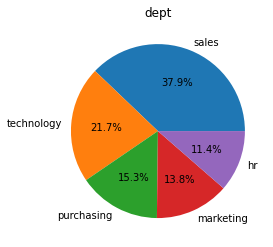

<Figure size 720x720 with 0 Axes>

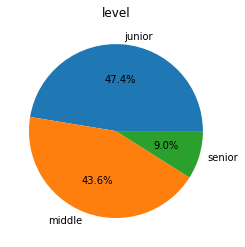

<Figure size 720x720 with 0 Axes>

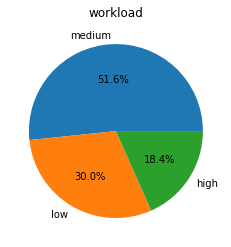

<Figure size 720x720 with 0 Axes>

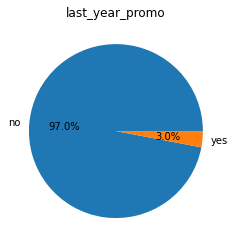

<Figure size 720x720 with 0 Axes>

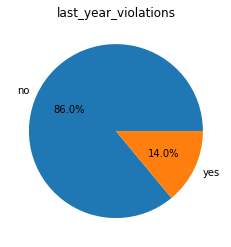

<Figure size 720x720 with 0 Axes>

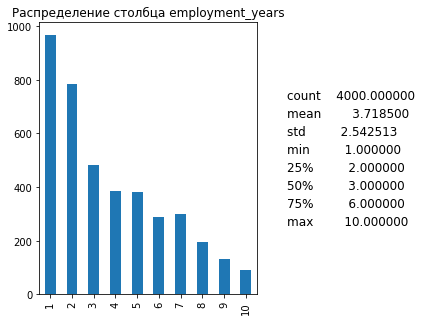

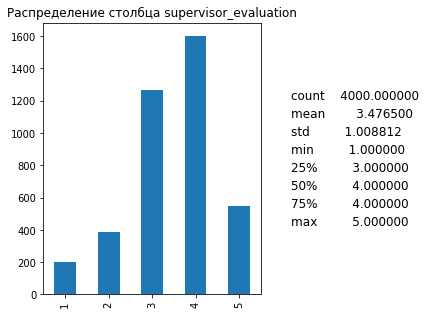

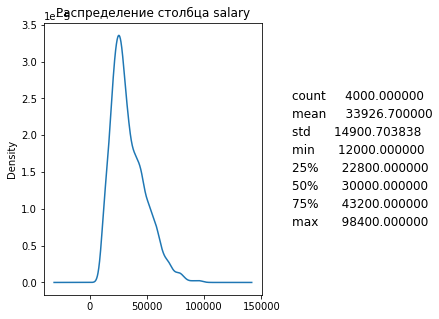

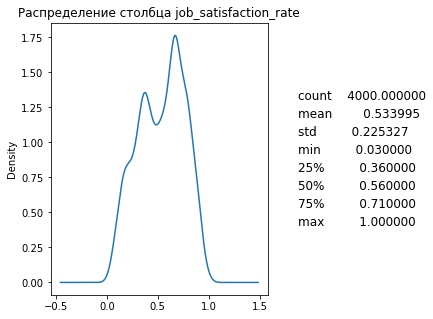

In [14]:
columns_analysis(df_train_job_satisfaction)

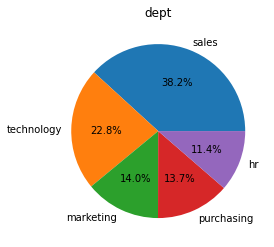

<Figure size 720x720 with 0 Axes>

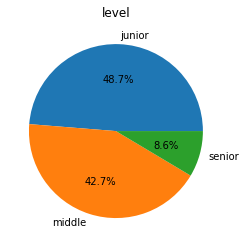

<Figure size 720x720 with 0 Axes>

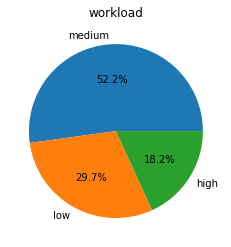

<Figure size 720x720 with 0 Axes>

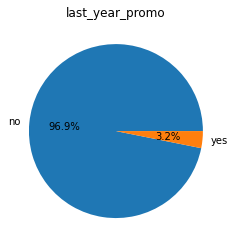

<Figure size 720x720 with 0 Axes>

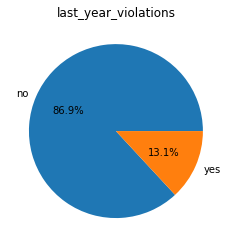

<Figure size 720x720 with 0 Axes>

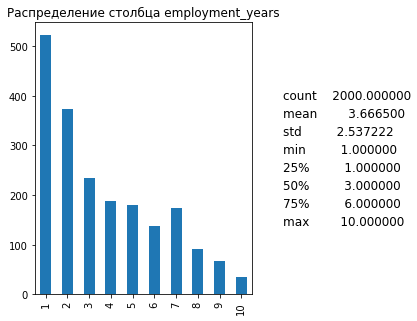

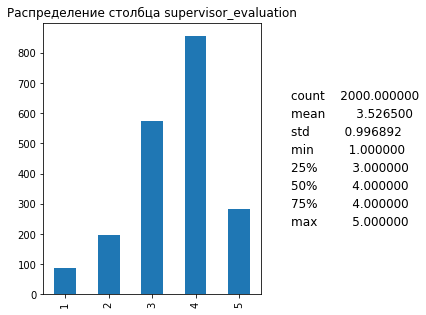

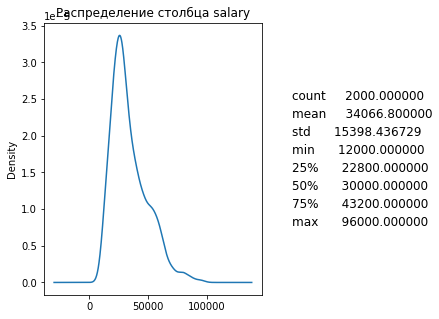

In [15]:
columns_analysis(df_test_features)

Как видно большинство сотрудников работает в отделах продаж и технологий, доля джуниор и мидл специалистов примерна равна и сумме даёт 91%, малая же доля сениоров всего 9%, почти у половины сотрудников средний уровень загруженности и при этом подавляюющее большинство рабочих не нарушало трудовой договор и не получала повышений за последний год. При этом значимых различий в двух выборках не обнаружено.

Рассмотрим статистический характириски цисловых столбцов.

In [16]:
df_train_job_satisfaction.describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


In [17]:
df_test_features.describe()

,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


Рассмотрим зависимость уровня удовлетворённости от других признаков

In [18]:
def target_depen_analysys(df, target):
    numeric_columns = df.drop(target, axis=1).select_dtypes(exclude='object').columns
    object_columns = df.drop(target, axis=1).select_dtypes(include='object').columns
    sns.set(style="whitegrid")
    for numeric in numeric_columns:
        fig, axes = plt.subplots(nrows=1, ncols=len(object_columns), figsize=(40, 10))
        i = 0
        for string in object_columns:
            scatter_plot = sns.scatterplot(x=target, y=numeric, hue=string, data=df, palette='Set2', ax=axes[i])
            scatter_plot.legend(title=string)
            plt.title(f'Зависимость {target} от {numeric}')
            i += 1
        plt.show()
    for numeric in numeric_columns:
        sns.scatterplot(x=target, y=numeric, data=df, alpha=0.2)
        plt.title(f'Зависимость {target} от {numeric}')
        plt.show()
    

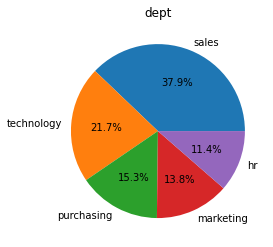

<Figure size 720x720 with 0 Axes>

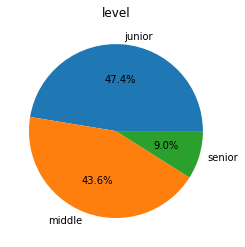

<Figure size 720x720 with 0 Axes>

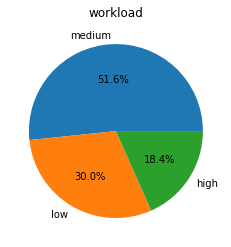

<Figure size 720x720 with 0 Axes>

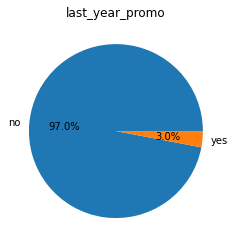

<Figure size 720x720 with 0 Axes>

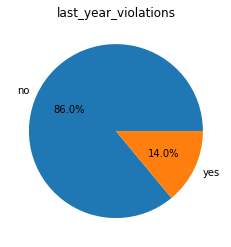

<Figure size 720x720 with 0 Axes>

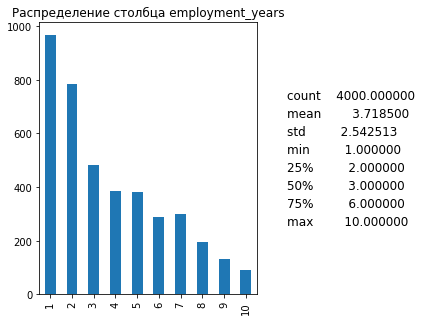

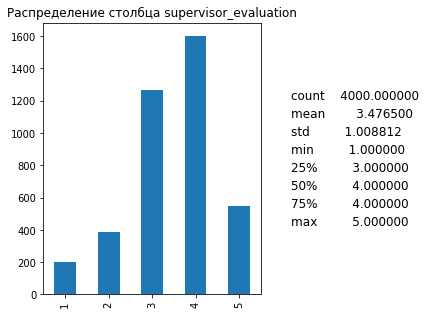

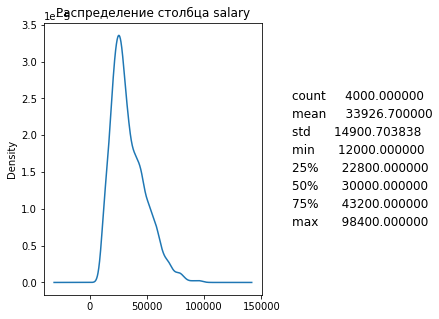

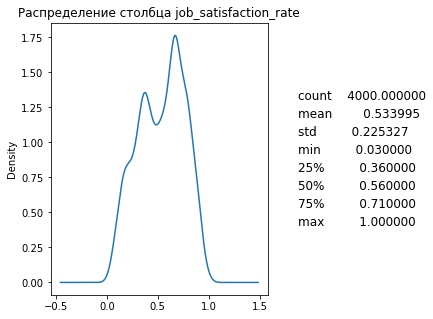

In [19]:
columns_analysis(df_train_job_satisfaction)

Можно отметить, что удовлетворённость работой выше у людей с высокой начальственной оценкой и ниже у тех, кто за последний год нарушал трудовой договор

In [20]:
interval_cols = list(df_train_job_satisfaction.drop(['supervisor_evaluation', 'employment_years'], axis=1).select_dtypes(exclude='object').columns)

{
    "zero": [
        "dept",
        "level",
        "workload"
    ],
    "weak": [
        "last_year_promo",
        "salary"
    ],
    "medium": [
        "employment_years"
    ],
    "notable": [
        "last_year_violations"
    ],
    "hight": [
        "supervisor_evaluation"
    ],
    "very_hight": [
        "job_satisfaction_rate"
    ]
}


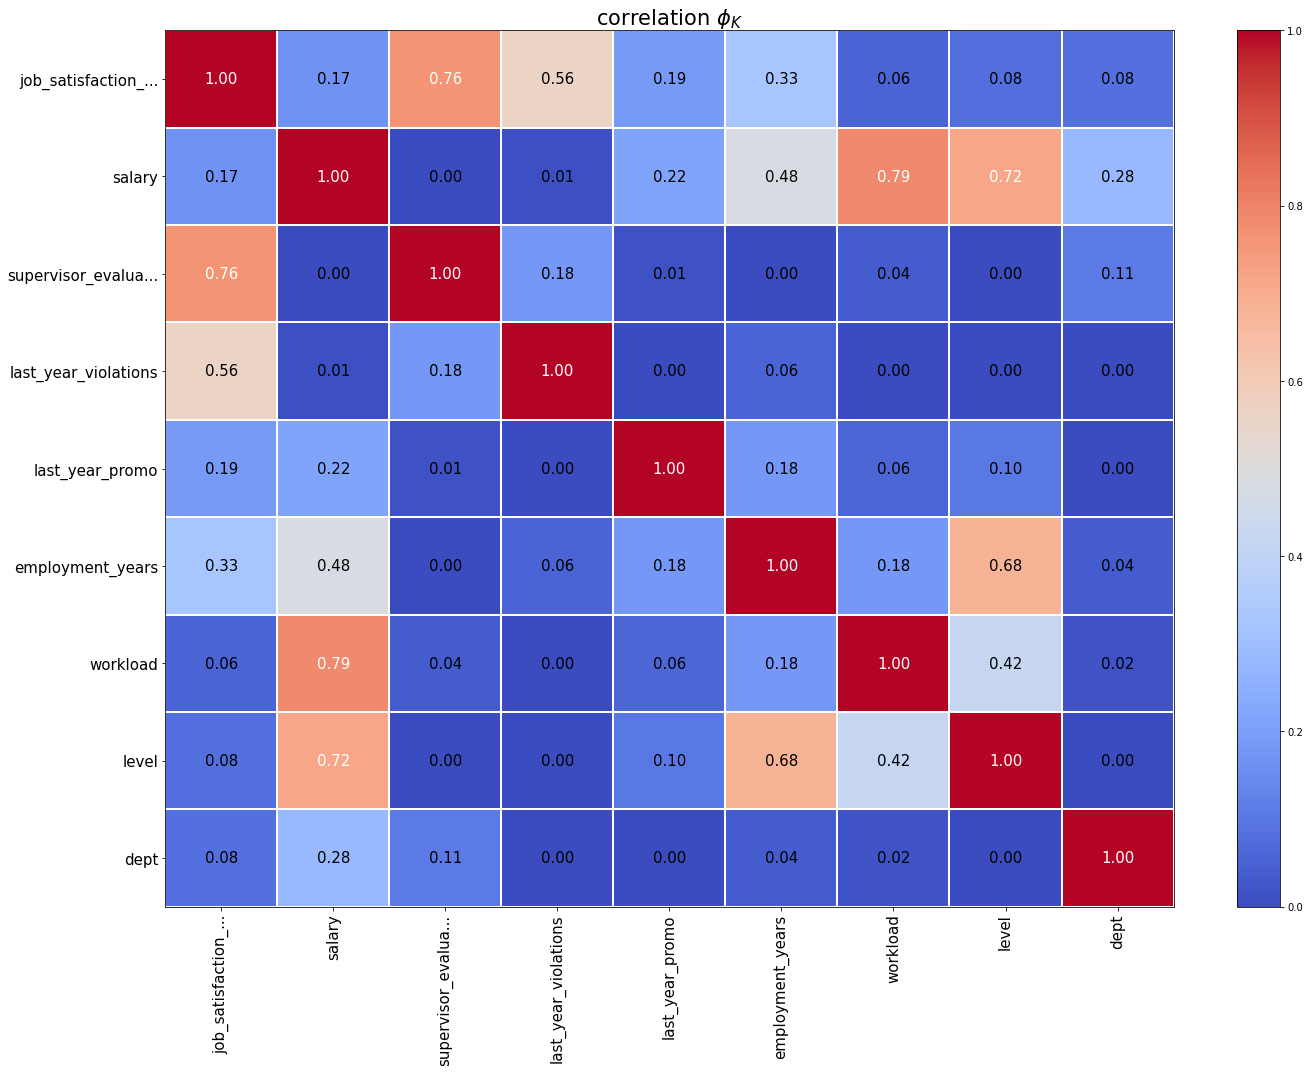

In [21]:
phik_overview = phik_matrix(df_train_job_satisfaction, interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='coolwarm',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

connection = {"zero" : [], "weak" : [], "medium" : [], "notable" : [], "hight" : [], "very_hight" : []}
for name, correlation_coefficient in zip(phik_overview['job_satisfaction_rate'].index, phik_overview['job_satisfaction_rate']):
    if correlation_coefficient <= 0.1:
        connection["zero"].append(name)
    elif correlation_coefficient <= 0.3:
        connection["weak"].append(name)
    elif correlation_coefficient <= 0.5:
        connection["medium"].append(name)
    elif correlation_coefficient <= 0.7:
        connection["notable"].append(name)
    elif correlation_coefficient <= 0.9:
        connection["hight"].append(name)
    elif correlation_coefficient <= 1:
        connection["very_hight"].append(name)
print(json.dumps(connection, indent=4))

Видим неплохой уровень корреляции между таргетом и признаками "employment_years", "last_year_violations", "supervisor_evaluation"

### Промежуточный вывод
По графикам видно видно большинство сотрудников работает в отделах продаж и технологий, доля джуниор и мидл специалистов примерна равна и сумме даёт 91%, малая же доля сениоров всего 9%, почти у половины сотрудников средний уровень загруженности и при этом подавляющее большинство рабочих не нарушало трудовой договор и не получала повышений за последний год. По ним также можно отметить, что удовлетворённость работой выше у людей с высокой начальственной оценкой и ниже у тех, кто за последний год нарушал трудовой договор. По матрице корреляции заметна высокая связь между исследуемой величиной и входными признаками, особенно высокая связь с признаками "employment_years", "last_year_violations", "supervisor_evaluation". При этом значимых различий в тестовой и тренировачной выборках не обнаружено.

## Подготовка данных

Проверим наличие дубликатов после идексации по id.

In [22]:
df_train_job_satisfaction.duplicated().sum()

245

Удалим их

In [23]:
df_train_job_satisfaction = df_train_job_satisfaction.drop_duplicates()

Разделим выборку на таргет и предикторы

In [24]:
RANDOM_STATE = 42
y_train = df_train_job_satisfaction['job_satisfaction_rate']
X_train = df_train_job_satisfaction.drop('job_satisfaction_rate', axis=1)

Создадим пайплайн для масштабирования и кодирования данных

In [25]:
num_columns = list(X_train.select_dtypes(exclude='object'))
ohe_columns = ['last_year_promo', 'last_year_violations', 'dept']
ord_columns = ['level', 'workload']

ohe_pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

ord_pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('encoder', OrdinalEncoder(
        handle_unknown='use_encoded_value', unknown_value= -1,
        categories=[['junior', 'middle', 'senior'], ['low', 'medium', 'high']])
    )
])
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler())
])

In [26]:
preprocessing_regression = ColumnTransformer(transformers=[
    ('ohe', ohe_pipeline, ohe_columns),
    ('num', num_pipeline, num_columns),
    ('ord', ord_pipeline, ord_columns)
], remainder='passthrough')

Трансформируем тестовую и ваоидационную выборку с помощью созданного пайплайна

In [27]:
X_train_transformed = preprocessing_regression.fit_transform(X_train)

## Моделирование

Создадим пайплайн для подбора модели

In [28]:
final_p = Pipeline(steps=[
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

Создадим сетку по которой будет происходить подбор

In [29]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 8),
        'models__min_samples_split': range(2, 8),
        'models__min_samples_leaf': range(1, 8),
        'models__max_features': range(2, 8),
    },
    {
        'models': [KNeighborsRegressor(n_jobs=-1)],
        'models__n_neighbors': range(2, 10),
        'models__weights': ['uniform', 'distance']
    },
    {
        'models': [Lasso(random_state=RANDOM_STATE)],
        'models__alpha': np.arange(0.05, 1, 0.05),
    },
    {
        'models': [Ridge(random_state=RANDOM_STATE)],
        'models__alpha': np.arange(0.05, 1, 0.05),
    },
    {
        'models': [ElasticNet(random_state=RANDOM_STATE)],
        'models__alpha': np.arange(0.05, 1, 0.2),
        'models__l1_ratio': np.arange(0.05, 1, 0.2),
    },
    {
        'models': [SVR()],
    }
]

Напишем собственную метрику SMAPE для подбора лучшей модели

In [30]:
def custom_metric(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    metric = np.sum((2 * np.abs(y_true - y_pred)) / (np.abs(y_true) + np.abs(y_pred))) * 100 / len(y_true)
    return metric

scorer = make_scorer(custom_metric, greater_is_better=False)

Теперь проведём моделирования и с помощью GridSearch подберём наилучшею модель, в качестве метрики будем использовать SMAPE

In [31]:
grid_search = GridSearchCV(
    final_p,
    param_grid,
    cv=5,
    scoring=scorer,
    n_jobs=-1,
)
grid_search.fit(X_train_transformed, y_train)
best_model_regression = grid_search.best_estimator_

In [32]:
print('Лучшая модель и её параметры:\n\n', best_model_regression)
print ('Метрика лучшей модели на кросс-валидации:', -grid_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('models', SVR())])
Метрика лучшей модели на кросс-валидации: 14.968074874472375


Посмотрим на ближайшие по качеству модели

In [33]:
results_df = pd.DataFrame(grid_search.cv_results_)
sorted_results = results_df.sort_values(by='mean_test_score', ascending=False)
print('Топ-5 лучших моделей:')
sorted_results[['params', 'mean_test_score']].head(5)

Топ-5 лучших моделей:


,params,mean_test_score
1591,{'models': SVR()},-14.968075
1521,"{'models': KNeighborsRegressor(n_jobs=-1), 'mo...",-16.323171
1523,"{'models': KNeighborsRegressor(n_jobs=-1), 'mo...",-16.354548
1525,"{'models': KNeighborsRegressor(n_jobs=-1), 'mo...",-16.384179
1517,"{'models': KNeighborsRegressor(n_jobs=-1), 'mo...",-16.390558


Поcмотрим результат на валидационной выборке

## Проверка модели на тестовой выборке

Соединим по id два датафрейма с тестовыми данными

In [34]:
df_merged = pd.merge(df_test_features, df_test_target_job_satisfaction_rate, left_index=True, right_index=True, how='inner')

Разделим обратно на 2 части

In [35]:
X_test = df_merged.drop('job_satisfaction_rate', axis=1)
y_test = df_merged['job_satisfaction_rate']

Трансформируем входные признаки

In [36]:
X_test_transformed = preprocessing_regression.transform(X_test)

Получим предсказанные значения для дальнейшего использования в классификации

In [37]:
test_job_satisfaction = best_model_regression.predict(X_test_transformed)

Посмотри полученную метрику на тестовых данных

In [38]:
custom_metric(test_job_satisfaction, y_test)

13.82968342909084

Проверим полученный результат на адекватность с помощью dummy модели

In [39]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train_transformed, y_train)

DummyRegressor()

Посмотрим метрику на тестовых данных

In [40]:
y_pred_dummy = dummy_model.predict(X_test)
custom_metric(y_test, y_pred_dummy)

38.26225790202237

Как видим она сильно больше полученной с помощью SVR модели.

### Лучшая модель
Для выбранной нами метрики SMAPE наилучшей оказалась модель SVR, также неплохой результат показали k-means модели, при этом линейных моделей в топе не оказалось, это говорит о вероятной нелинейной связи между признаками

# Задача 2: предсказание увольнения сотрудника из компании

## Первичный осмотр данных

In [41]:
print(df_train_quit.info())
df_train_quit.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
5,699916,sales,junior,low,1,no,yes,3,18000,yes
6,417070,technology,middle,medium,8,no,no,2,44400,no
7,165489,sales,middle,low,4,no,no,5,19200,no
8,996399,marketing,middle,low,7,no,no,4,25200,no
9,613206,technology,middle,medium,2,no,no,3,45600,yes


In [42]:
print(df_test_target_quit.info())
df_test_target_quit.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
5,223063,no
6,810370,no
7,998900,no
8,578329,no
9,648850,no


## Предобработка данных

Посмотрим на наличие пропусков и дубликатов в данных

In [43]:
dup_pass_amount(df_train_quit)

Количество пропусков:
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

Количество дубликатов =  0
уникальные значения столбца dept : ['sales' 'purchasing' 'marketing' 'technology' 'hr']
уникальные значения столбца level : ['middle' 'junior' 'sinior']
уникальные значения столбца workload : ['high' 'medium' 'low']
уникальные значения столбца last_year_promo : ['no' 'yes']
уникальные значения столбца last_year_violations : ['no' 'yes']
уникальные значения столбца quit : ['no' 'yes']


Исправим опечатку в столбце level

In [44]:
df_train_quit['level'] = df_train_quit['level'].replace('sinior', 'senior')

Для удобства сделаем индексацию по id

In [45]:
df_train_quit.set_index('id', inplace=True)
df_test_target_quit.set_index('id', inplace=True)

### Промежуточный вывод по предобработке
Данные пришли в замечательном качества - дубликатов не обнаружено, а пропусков малое количество, их заролним при работе с пайплайном. При предобработке была лишь сделана индексация по id.

## Исследовательсткий анализ

Напишем функции для анализа столбцов в зависимости от увольнения сотрудника

In [46]:
def columns_categorial_analysis(df):
    df_quit_no = df[df['quit'] == 'no']
    df_quit_yes = df[df['quit'] == 'yes']

    for i, column in enumerate(df.drop('quit', axis = 1).select_dtypes(include='object').columns):
        gs = GridSpec(1, 2, width_ratios=[2, 2], wspace=1, figure=plt.figure(figsize=(20, 20)))
        ax1 = plt.subplot(gs[0])
        df_quit_no[column].value_counts().plot.pie(autopct='%1.1f%%')
        ax1.set_title(f'No Quit - {column}')
        ax1.set_ylabel('')
        ax1.set_aspect('equal')
        ax2 = plt.subplot(gs[1], sharey=ax1)
        df_quit_yes[column].value_counts().plot.pie(autopct='%1.1f%%')
        ax2.set_title(f'Quit - {column}')
        ax2.set_ylabel('')
        plt.show()
        ax2.set_aspect('equal')
    for column in df.select_dtypes(exclude='object').columns:
        if df[column].nunique() < 15:
            gs = GridSpec(1, 2, width_ratios=[2, 2], wspace=1, figure=plt.figure(figsize=(12, 4)))
            ax1 = plt.subplot(gs[0])
            ax2 = plt.subplot(gs[1])
            df_quit_no[column].value_counts().sort_index().plot.bar(alpha=0.5, color='red', label='No Quit', ax=ax1)
            df_quit_yes[column].value_counts().sort_index().plot.bar(alpha=0.5, color='green', label='Quit', ax=ax2)
        ax1.set_title(f'No Quit - {column}')
        ax1.set_ylabel('')
        ax2.set_title(f'Quit - {column}')
        ax2.set_ylabel('')
        plt.show()

In [47]:
def columns_numeric_analysis(df):
    df_quit_no = df[df['quit'] == 'no']
    df_quit_yes = df[df['quit'] == 'yes']
    for column in df.select_dtypes(exclude='object').columns:
        if df[column].nunique() > 15:
            gs = GridSpec(1, 3, width_ratios=[5, 2, 2], wspace=1, figure=plt.figure(figsize=(12, 5)))
            ax1 = plt.subplot(gs[0])
            df_quit_no[column].plot.kde(color='red', label='No Quit')
            df_quit_yes[column].plot.kde(color='green', label='Quit')
            plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
            ax1.set_title(f"Распределение столбца {column}")
            ax2 = plt.subplot(gs[1])
            text = df_quit_no[column].describe().to_string()
            ax2.text(0, 0.5, text, ha='left', va='center', fontsize=12, linespacing=1.5)
            ax2.axis('off')
            ax2.set_title(f"Quit No - {column}")
            ax3 = plt.subplot(gs[2])
            text = df_quit_yes[column].describe().to_string()
            ax3.text(0, 0.5, text, ha='left', va='center', fontsize=12, linespacing=1.5)
            ax3.axis('off')
            ax3.set_title(f"Quit - {column}")
            plt.show()

Воспользуемся написанной функцией

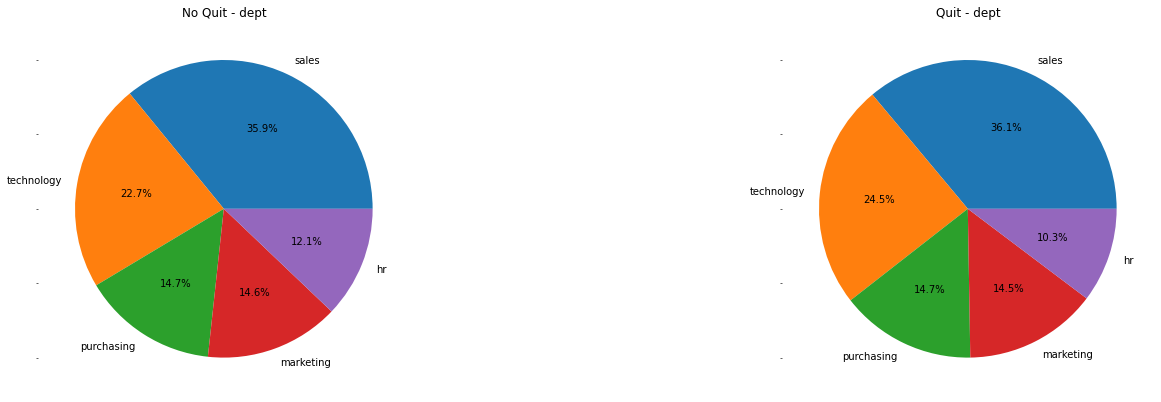

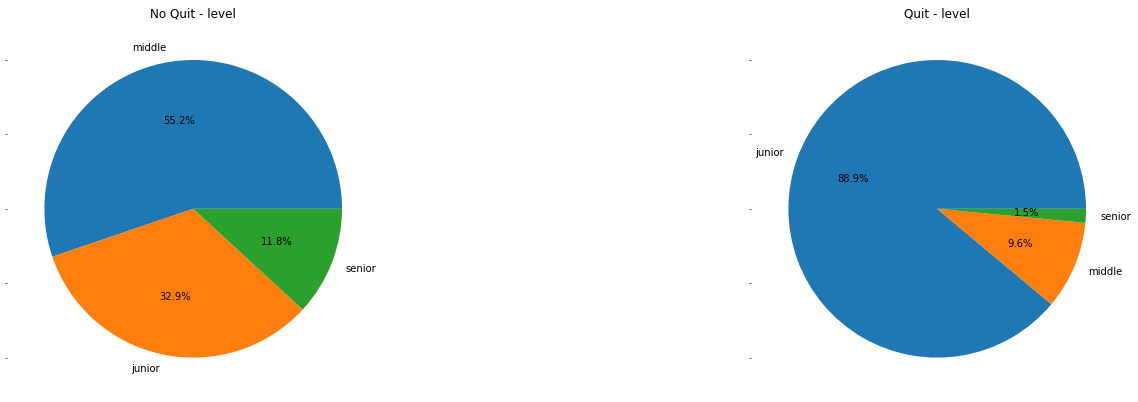

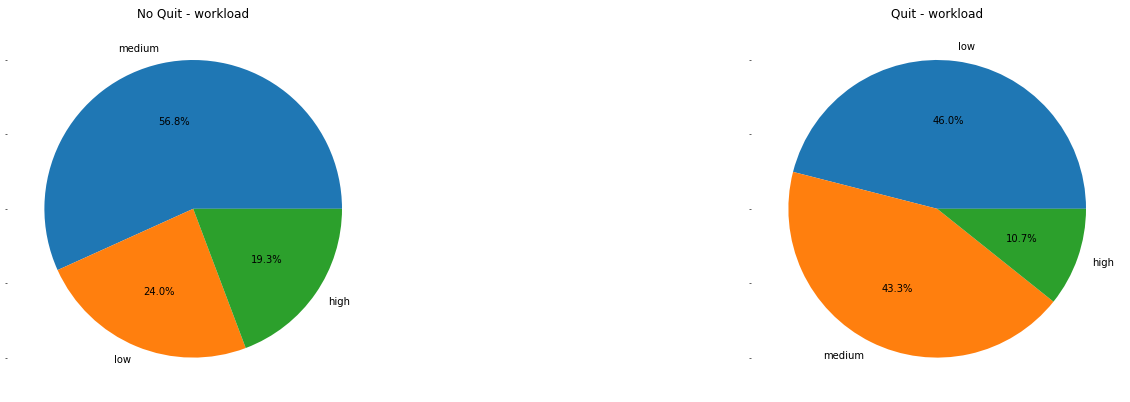

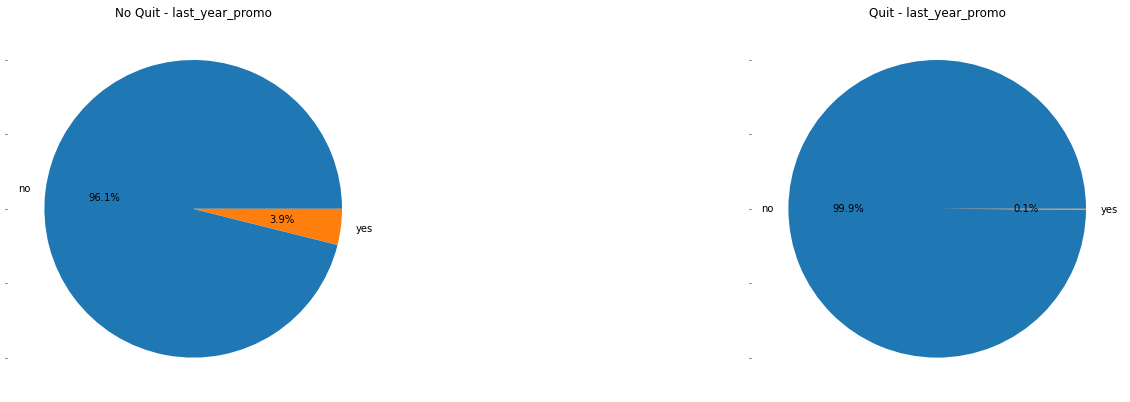

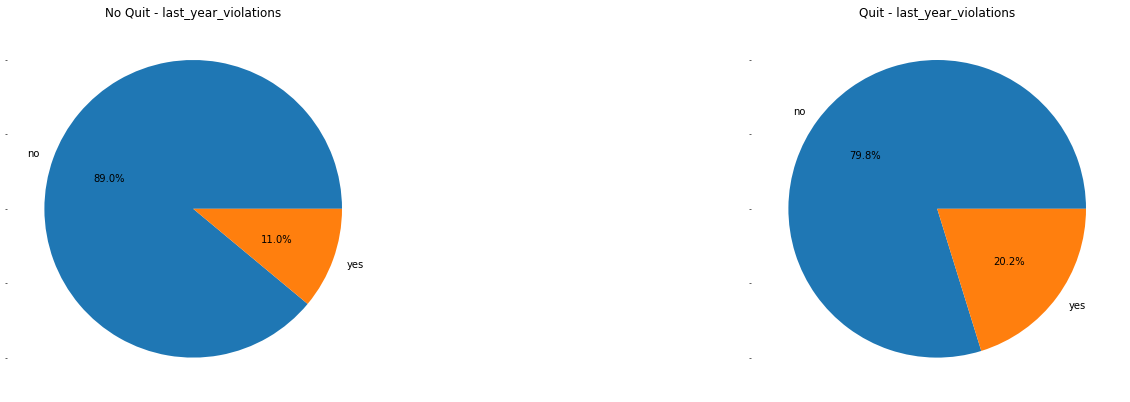

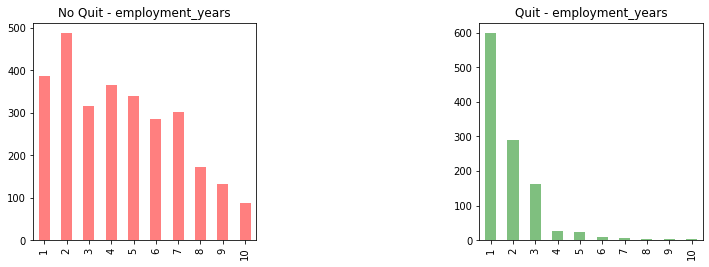

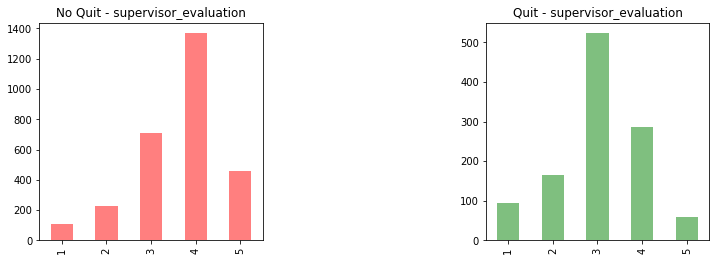

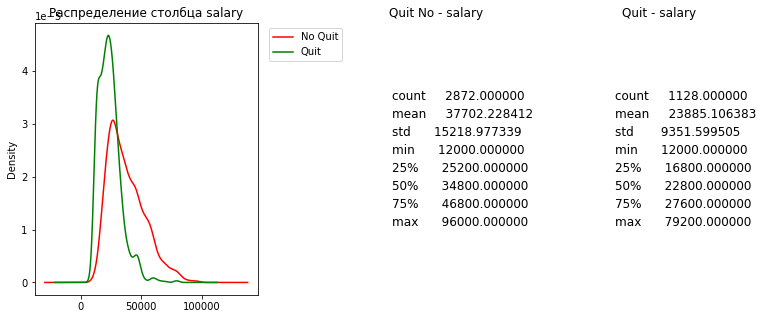

In [48]:
columns_categorial_analysis(df_train_quit)
columns_numeric_analysis(df_train_quit)

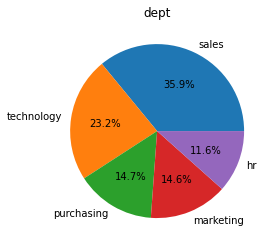

<Figure size 720x720 with 0 Axes>

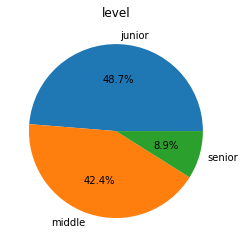

<Figure size 720x720 with 0 Axes>

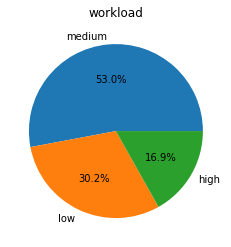

<Figure size 720x720 with 0 Axes>

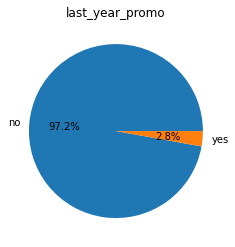

<Figure size 720x720 with 0 Axes>

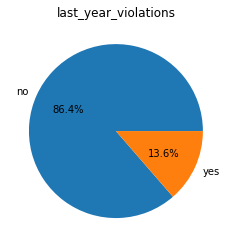

<Figure size 720x720 with 0 Axes>

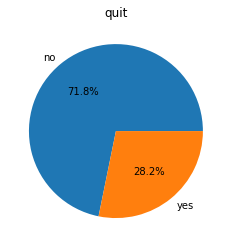

<Figure size 720x720 with 0 Axes>

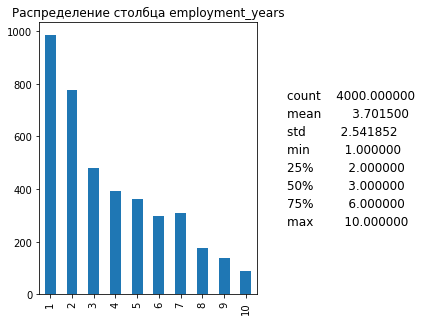

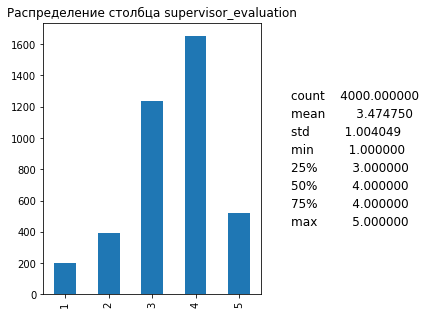

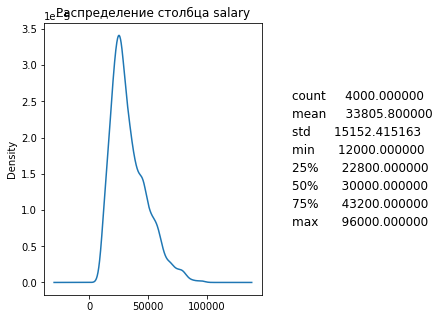

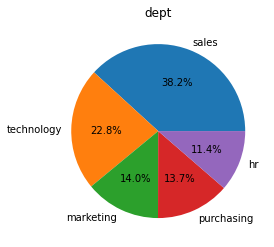

<Figure size 720x720 with 0 Axes>

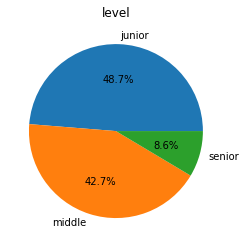

<Figure size 720x720 with 0 Axes>

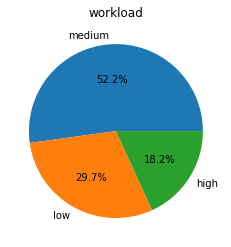

<Figure size 720x720 with 0 Axes>

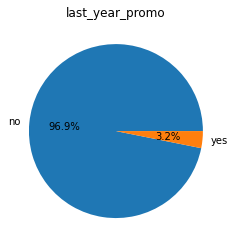

<Figure size 720x720 with 0 Axes>

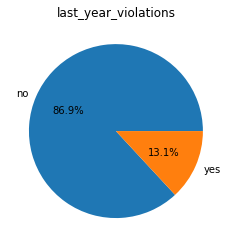

<Figure size 720x720 with 0 Axes>

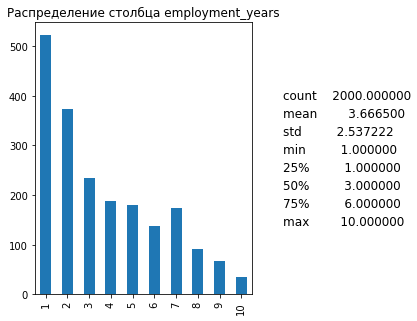

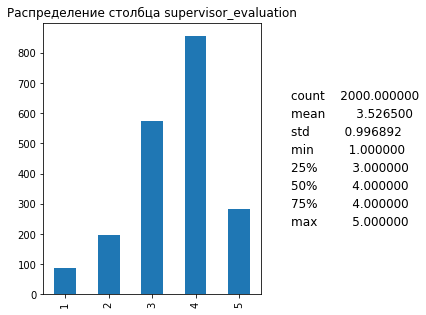

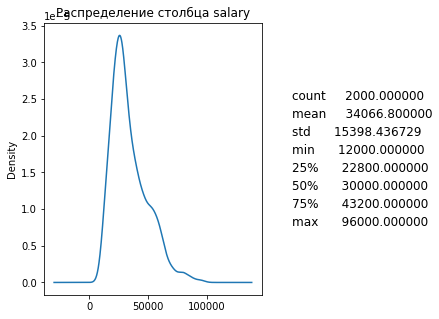

In [49]:
columns_analysis(df_train_quit)
columns_analysis(df_test_features)

По графикам видно, что отдел практически не влияет на увольняемость сотрудников, при это среди уволившихся на удивлении много junior разработчиков и людей с малой нагрузкой, также видим практически полной отсутствие уволившихся, среди людей получивших недавнее повышение. Оценка уволившихся сотрудников начальством чаще ниже, как и их зарплаты, при это с увеличением стажа уменьшается и вероятность увольнения работника. В данном случае тоже нет явных отличий между тестовой и тренировочной выборкой.

In [50]:
df_train_quit.describe()

,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000
mean,3.701500,3.474750,33805.800000
std,2.541852,1.004049,15152.415163
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


In [51]:
df_test_features.describe()

,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


{
    "zero": [
        "dept"
    ],
    "weak": [
        "workload",
        "last_year_promo",
        "last_year_violations",
        "supervisor_evaluation"
    ],
    "medium": [
        "level"
    ],
    "notable": [
        "employment_years",
        "salary"
    ],
    "hight": [],
    "very_hight": [
        "quit"
    ]
}


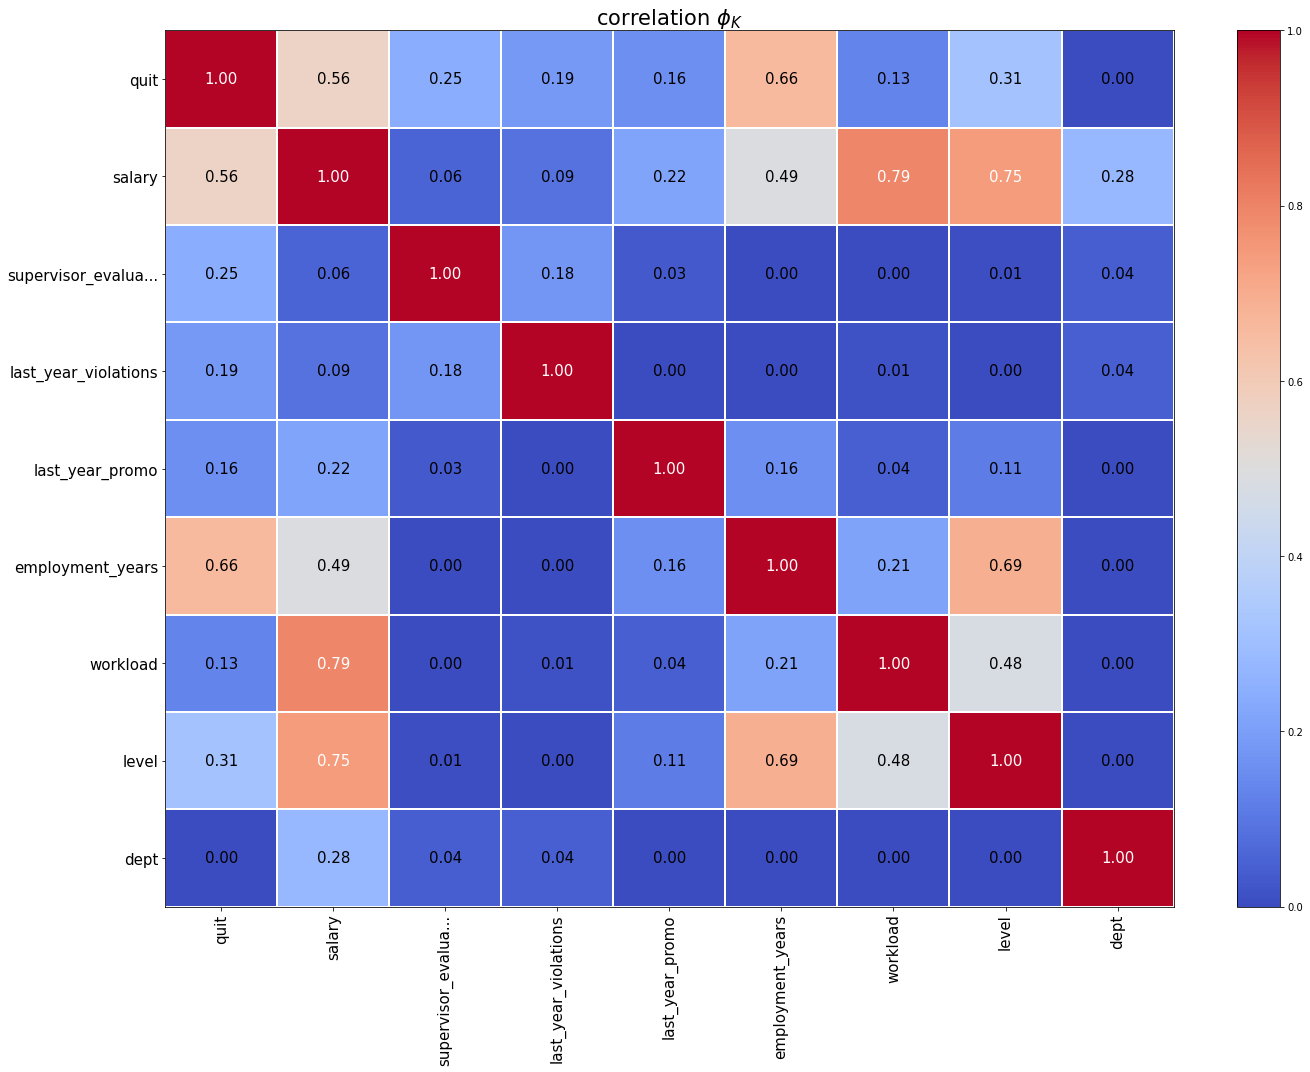

In [52]:
interval_cols = list(df_train_quit.drop(['supervisor_evaluation', 'employment_years'], axis=1).select_dtypes(exclude='object').columns)
phik_overview = phik_matrix(df_train_quit, interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='coolwarm',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

connection = {"zero" : [], "weak" : [], "medium" : [], "notable" : [], "hight" : [], "very_hight" : []}
for name, correlation_coefficient in zip(phik_overview['quit'].index, phik_overview['quit']):
    if correlation_coefficient <= 0.1:
        connection["zero"].append(name)
    elif correlation_coefficient <= 0.3:
        connection["weak"].append(name)
    elif correlation_coefficient <= 0.5:
        connection["medium"].append(name)
    elif correlation_coefficient <= 0.7:
        connection["notable"].append(name)
    elif correlation_coefficient <= 0.9:
        connection["hight"].append(name)
    elif correlation_coefficient <= 1:
        connection["very_hight"].append(name)
print(json.dumps(connection, indent=4))

Составим портрет уволившегося сотрудника и сравним его со средним

In [53]:
def make_portret(df):
    result = pd.DataFrame()
    for column in df.columns:
        most_frequent_value = df[column].mode().iloc[0]
        result[column] = [most_frequent_value]
    return result

In [54]:
comparing = pd.concat([
    make_portret(df_train_quit[df_train_quit['quit'] == 'yes']),
    make_portret(df_train_quit[df_train_quit['quit'] == 'no']),
    make_portret(df_train_quit)
], axis=0)
comparing.index = (['quit_yes'], ['quit_no'], ['quit_average'])
comparing

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
"(quit_yes,)",sales,junior,low,1,no,no,3,12000,yes
"(quit_no,)",sales,middle,medium,2,no,no,4,27600,no
"(quit_average,)",sales,junior,medium,1,no,no,4,24000,no


Уволившийся сотрудник в среднем это junior специалист с малой нагрузкой, годом стажа и зарплатой 12000. Чётко видно, что зарплата уволившихся в среднем в 2 раза меньше оставшихся.

Теперь проверим теорию, о том что хорошая удовлетворённость рабочим местом не даёт уволиться сотруднику, для этого объединим таблицы и посмотрим корреляцию

In [55]:
df_test_merged = pd.merge(df_test_target_quit, df_test_target_job_satisfaction_rate, left_index=True, right_index=True, how='inner')

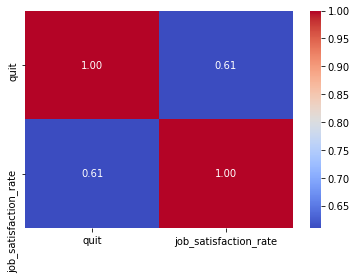

In [56]:
interval_cols = list(df_test_merged.select_dtypes(exclude='object').columns)
phik_overview = phik_matrix(df_test_merged, interval_cols=interval_cols)
sns.heatmap(phik_overview, annot=True, fmt='.2f', cmap='coolwarm');

Видим что присутствует реальная зависимость, так что при подготовке данных стоит добавить этот признак.

### Промежуточный вывод по исследовательскому анализу
По графикам видно, что отдел практически не влияет на увольняемость сотрудников, при это среди уволившихся на удивлении много junior разработчиков и людей с малой нагрузкой, также видим практически полной отсутствие уволившихся, среди людей получивших недавнее повышение. Оценка уволившихся сотрудников начальством чаще ниже, как и их зарплаты, при это с увеличением стажа уменьшается и вероятность увольнения работника. Заметная корреляция была выявлена между тарегтом и такими признаками как стаж, зарплата и удовлетворённость рабочим местом. Было выявлено, что уволившийся сотрудник в среднем это junior специалист с малой нагрузкой, годом стажа и зарплатой 12000. Чётко видно, что зарплата уволившихся в среднем в 2 раза меньше оставшихся.

## Подготовка данных

In [57]:
y_train = df_train_quit['quit']
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
X_train = df_train_quit.drop('quit', axis=1)

Для начала масштабируем и закодируем признаки используя пайплайн из прошлой задачи

In [58]:
X_train_transformed = preprocessing_regression.fit_transform(X_train)

Получим предсказанные значения удовлетворённостью работой и добавим их к входным признакам

In [59]:
job_satisfaction_train = best_model_regression.predict(X_train_transformed)
X_train['job_satisfaction_rate'] = job_satisfaction_train

Создадим пайплайны для обучения

In [60]:
num_columns = list(X_train.select_dtypes(exclude='object').columns)
ohe_columns = ['last_year_promo', 'last_year_violations', 'dept']
ord_columns = ['level', 'workload']

ohe_pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

ord_pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('encoder', OrdinalEncoder(
        handle_unknown='use_encoded_value', unknown_value= -1,
        categories=[['junior', 'middle', 'senior'], ['low', 'medium', 'high']])
    )
])
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler())
])


In [61]:
preprocessing_classification = ColumnTransformer(transformers=[
    ('ohe', ohe_pipeline, ohe_columns),
    ('num', num_pipeline, num_columns),
    ('ord', ord_pipeline, ord_columns)
], remainder='passthrough')
final_p = Pipeline(steps=[
    ('preprocessor', preprocessing_classification),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [62]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': (None, *range(2, 6)),
        'models__min_samples_split': range(3, 10),
        'models__min_samples_leaf': range(2, 9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C':  np.arange(0.5, 3, 0.5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
]

Теперь проведём моделирования и с помощью GridSearch подберём наилучшую модель, а также способы кодирования и масштабирования признаков. В качестве метрики будем использовать roc_auc score.

In [63]:
grid_search = GridSearchCV(
    final_p,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_model_classification = grid_search.best_estimator_
print('Лучшая модель и её параметры:\n\n', best_model_classification)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                        

Посмотрим на ближайшие по качеству модели.

In [64]:
results_df = pd.DataFrame(grid_search.cv_results_)

sorted_results = results_df.sort_values(by='mean_test_score', ascending=False)

print('Топ-5 лучших моделей:')
sorted_results[['params', 'mean_test_score']].head(5)

Топ-5 лучших моделей:


,params,mean_test_score
478,"{'models': DecisionTreeClassifier(max_depth=4,...",0.928215
469,"{'models': DecisionTreeClassifier(max_depth=4,...",0.928215
462,"{'models': DecisionTreeClassifier(max_depth=4,...",0.928215
463,"{'models': DecisionTreeClassifier(max_depth=4,...",0.928215
464,"{'models': DecisionTreeClassifier(max_depth=4,...",0.928215


## Анализ важности признаков

In [65]:
X_train_transformed = best_model_classification.named_steps['preprocessor'].fit_transform(X_train)
explainer = shap.explainers.Permutation(best_model_classification.named_steps['models'].predict_proba, X_train_transformed)
feature_names = best_model_classification.named_steps['preprocessor'].get_feature_names_out()
df_X_train_transformed = pd.DataFrame(X_train_transformed, columns=feature_names)
shap_values = explainer(df_X_train_transformed)
shap_values = shap_values[..., 1]

PermutationExplainer explainer: 4001it [01:00, 58.79it/s]                          


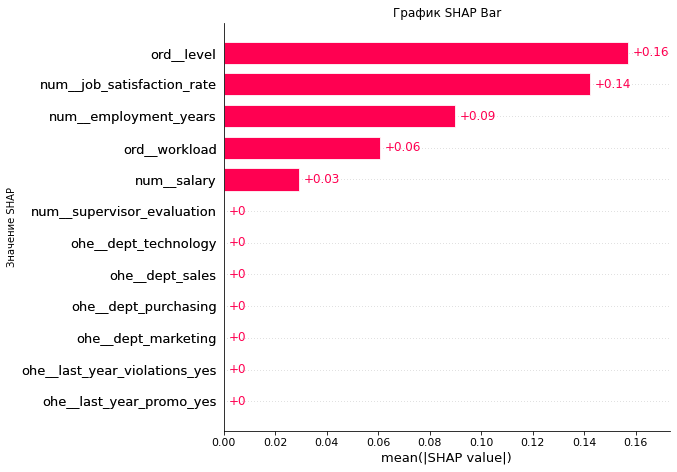

In [66]:
plt.ylabel("Значение SHAP")
plt.title("График SHAP Bar")
shap.plots.bar(shap_values, max_display=22)
plt.show()

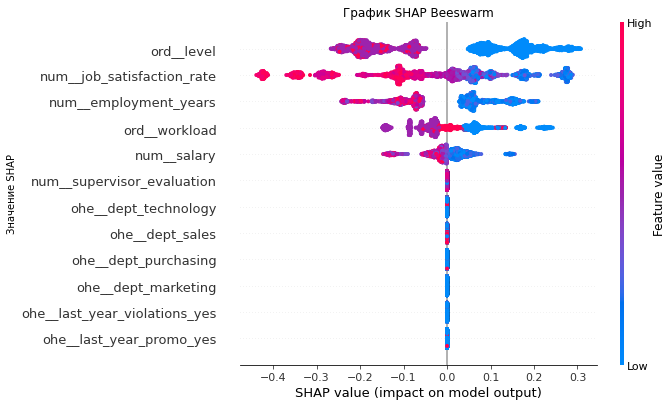

In [67]:
plt.ylabel("Значение SHAP")
plt.title("График SHAP Beeswarm")
shap.plots.beeswarm(shap_values, max_display=22)
plt.show()

Как видим отдел, загрузка, наличие нарушений и повышений за прошлый год практически никак не влияют на модель, так что попробуем без них. При этом признаки с высокой важностью, такие как стаж, зарплата, должность, удовлетворений работой и оценка руководителя при повышении ведут к снижению вероятности увольнения

In [68]:
df_train_quit_optimal = df_train_quit.drop(['supervisor_evaluation', 'dept', 'last_year_violations', 'last_year_promo'], axis=1)
df_train_quit_optimal['job_satisfaction'] = job_satisfaction_train

In [69]:
num_columns = list(df_train_quit_optimal.select_dtypes(exclude='object'))
ord_columns = ['level', 'workload']

In [70]:
ord_pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=[['junior', 'middle', 'senior'], ['low', 'medium', 'high']]))
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler())
])


preprocessing_quite_optimal = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_columns),
    ('ord', ord_pipeline, ord_columns),
], remainder='passthrough')

final_p_optimal = Pipeline(steps=[
    ('preprocessing', preprocessing_quite_optimal),
    ('models', LogisticRegression(C=1, penalty='l1', random_state=RANDOM_STATE, solver='liblinear'))
])

In [71]:
y_train_optimal = df_train_quit_optimal['quit']
X_train_optimal = df_train_quit_optimal.drop('quit', axis=1)

In [72]:
from sklearn.model_selection import cross_val_score
model_metric = cross_val_score(final_p_optimal, X_train_optimal, y_train_optimal, cv=5, scoring='roc_auc').mean()
print("Roc_auc score на кросс-валидации =", model_metric)

Roc_auc score на кросс-валидации = 0.9167490178494155


При удалении ненужных признаков метрика незначительно понизилась

### Промежуточный вывод по важности признаков
Было выяснено, что отдел, загрузка, наличие нарушений и повышений за прошлый год практически никак не влияют на модель. При этом признаки с высокой важностью, такие как стаж, зарплата, должность, удовлетворений работой и оценка руководителя при повышении ведут к снижению вероятности увольнения. Было проведено моделировании при удалении ненужных признаков, при этом к сожалению метрика незначительно понизилась.

## Проверка на тестовой выборке
При удалении ненужных признаков метрика незначительно упала, поэтому попробуем использовать первую модель со всеми признаками

Сначала добавим уровень удовлетворённости работой

In [73]:
df_merged = pd.merge(df_test_features, df_test_target_quit, left_index=True, right_index=True, how='inner')

Выделим таргет и входные признаки

In [74]:
y_test = df_merged['quit']
y_test = label_encoder.transform(y_test)
X_test = df_merged.drop(['quit'], axis=1)

In [75]:
X_test_transformed = preprocessing_regression.transform(X_test)
job_satisfaction_test = best_model_regression.predict(X_test_transformed)
X_test['job_satisfaction_rate'] = job_satisfaction_test

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.794850
686555,hr,junior,medium,1,no,no,4,30000,0.732163
467458,sales,middle,low,5,no,no,4,19200,0.636815
418655,sales,middle,low,6,no,no,4,19200,0.675020
789145,hr,middle,medium,5,no,no,5,40800,0.694680
...,...,...,...,...,...,...,...,...,...
393147,marketing,junior,low,3,no,no,3,20400,0.577188
109582,technology,middle,low,3,no,no,2,21600,0.158527
305653,technology,junior,low,1,no,no,3,14400,0.233954


In [76]:
probabilities = best_model_classification.predict_proba(X_test)[:, 1]
print("Roc_auc score на тестовой выборке =", roc_auc_score(y_test, probabilities))

Roc_auc score на тестовой выборке = 0.9222457229498804


Проверка на адекватность

In [77]:
num_columns = list(X_train.select_dtypes(exclude='object').columns)
ohe_columns = ['last_year_promo', 'last_year_violations', 'dept']
ord_columns = ['level', 'workload']
final_p_dummy = Pipeline(steps=[
    ('preprocessor', preprocessing_classification),
    ('models', DummyClassifier(strategy='stratified'))
])

In [78]:
final_p_dummy.fit(X_train, y_train);

In [79]:
probabilities_dummy = final_p_dummy.predict_proba(X_test)[:, 1]
print("Roc_auc score на тестовой выборке =", roc_auc_score(y_test, probabilities_dummy))

Roc_auc score на тестовой выборке = 0.5000666745688378


Как видим roc-auc score сильно ниже, чем у подобранной модели

### Промежуточный вывод по подбору модели
Наша модель подходит под условия клиента и замечательно проходит проверку на адекватность.Все наилучшие модели это решаюшие деревья, так что опять же можем заметить явную нелинейную связь.

## Общий вывод
В ходе этой работы мы выполняли 2 задача - прогнозирования уровня удовлетворённости работой и возможное увольнения сотрудника. Каждая задача была разделена на несколько этапов - загрузка и предобработка данных,  исследовательский анализ, подготовка данных и последующее моделирование.
Задача 1:
* Данные пришли в замечательном качестве - дубликатов не былообнаружено, а пропусков малое количество, их заполнил работе с пайплайном. При предобработке была лишь сделана индексация по id.
* При исследовательском анализе большинство сотрудников работает в отделах продаж и технологий, доля джуниор и мидл специалистов примерна равна и сумме даёт 91%, малая же доля сениоров всего 9%, почти у половины сотрудников средний уровень загруженности и при этом подавляющее большинство рабочих не нарушало трудовой договор и не получала повышений за последний год. По ним также можно отметить, что удовлетворённость работой выше у людей с высокой начальственной оценкой и ниже у тех, кто за последний год нарушал трудовой договор. По матрице корреляции заметна высокая связь между исследуемой величиной и входными признаками, особенно высокая связь с признаками "employment_years", "last_year_violations", "supervisor_evaluation"
* При подготовке данных мы использовали SimpleImputer для заполнения пропусков, OneHotEncoder и OrdinalEncoder для кодирования категориальных признаков и StandardScaler для масштабирования численных.
* Подбор наилучшей модели производился с помощью GridSearch по собственноручно написанной метрике SMAPE.  Для выбранной нами метрики наилучшей оказалась модель SVR, также неплохой результат показали k-means модели, при этом линейных моделей в топе не оказалось, это говорит о вероятной нелинейной связи между признаками. Наилучшее значение метрики было у модели была выбрана SVR - на валидационных данных она показала результат SMAPE = 14.96, на тестовых же метрика уменьшилась и была равна 13.82.

Задача 2:
* Никаких заметных огрехов в данных было не обнаружено - дубликатов не обнаружено, а пропусков малое количество, их заполнили при работе с пайплайном. При предобработке была лишь сделана индексация по id.
* По построенным нами графикам видно, что отдел практически не влияет на увольняемость сотрудников, при это среди уволившихся на удивлении много junior разработчиков и людей с малой нагрузкой, также видим практически полной отсутствие уволившихся, среди людей получивших недавнее повышение. Было выявлено, что уволившийся сотрудник в среднем это junior специалист с малой нагрузкой, годом стажа и зарплатой 12000. Чётко видно, что зарплата уволившихся в среднем в 2 раза меньше оставшихся. Оценка уволившихся сотрудников начальством чаще ниже, как и их зарплаты, при это с увеличением стажа уменьшается и вероятность увольнения работника. Заметная корреляция была выявлена между тарегтом и такими признаками как стаж, зарплата и удовлетворённость рабочим местом. 
* Для подготовки данных к моделированию был использован пайплайн из прошлой задачи.
* После первичного моделировании было выяснено, что отдел, загрузка, наличие нарушений и повышений за прошлый год практически никак не влияют на модель. При этом признаки с высокой важностью, такие как стаж, зарплата, должность, удовлетворений работой и оценка руководителя при повышении ведут к снижению вероятности увольнения. Было проведено о моделировании при удалении ненужных признаков, при этом к сожалению метрика незначительно понизилась.
* В данной задаче опять использовался GridSearch, но подбор производился по метрике roc-auc score.Лучшей моделью стало DecisionTreeClassifier(max_depth=4, min_samples_leaf=3, min_samples_split=3, random_state=42) с roc_auc score = 0.92 на кросс-валидации и 0.92 на тестовой выборке

В целом обе задачи были выполнены, обе модели выполняют свою работу в соответствии с требованиями заказчика. Как было выяснено основные факторы влияющие на возможность ухода это стаж, зарплата, должность и удовлетворённость рабочим местом. В ходе исследования мы увидели большую текучку junior специалистов, недавно устроившихся на работу и при этом получающих относительно малую зарплату. Скорее всего это нормальная ситуации для it компаний, но я посоветовал бы использовать для них внеденежные способы мотивации, такие как создание благоприятной окружающей среды. Также возможно добавление большего количества промежуточных должностей, ведь судя по графикам в ближайший год после повышения люди практически не увольняются.
